In [16]:
#%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
import time
import sys
from tqdm import tqdm



batch_size = 100
label_size = 5

images = tf.placeholder( tf.float32, shape=[None, 25, 25, 2], name="images" )
labels = tf.placeholder( tf.float32, shape=[None, label_size], name="labels" )

l_rate =  1e-8

# ==================================================================
def load_imgs(labellist = [0,1], size=25, directory = "class_dir/", dirNames=["class1", "class2"]):
    data = np.zeros(( 25000, size, size,2))
    labels = np.zeros(( 25000, len(dirNames) ))
    index = 0
    for label in labellist:
    	
        file_dir = directory+dirNames[label]
        filenamelist = os.listdir(file_dir)
        keep = 5000 # how many in file do we load
        filenamelist = filenamelist[:keep]
        for i in xrange(keep):
            fullfilepath = file_dir+"/"+filenamelist[i]
            if ".DS_Store" not in fullfilepath:
                img = Image.open( fullfilepath.rstrip() )
                data[ index, :, :] = np.array( img )
                labels[ index ][label] = 1
                index += 1

	c = list(zip(data, labels))
    random.shuffle(c)
    data, labels = zip(*c)

    #reshape back to tensor dims
    data = np.asarray(data)
    labels = np.asarray(labels)

    # # set some test data apart
#     print data.shape
#     print labels.shape
    return data[:20000,:], labels[:20000,:], data[20000:,], labels[20000:,]

def next_batch(s,e, data, labels):
    #print "trainSameImgs:", trainSameImgs[0]
    size = batch_size
    #print "size: 
    batchData = np.zeros(( size, 25, 25 , 2))
    batchLabels = np.zeros((size, labels.shape[1] ))
    trainImgs = data[s:e]
    
    for i in xrange(len(trainImgs)):
        batchData [ i ] = data[i]
        batchLabels[ i ] =  labels[i]

    c = list(zip(batchData, batchLabels))
    random.shuffle(c)
    batchData, batchLabels = zip(*c)

    return batchData, batchLabels

#
# ==================================================================
# ==================================================================
# ==================================================================
#
def max_pool_2x2(x):
    #max_pool_2x2 downsamples a feature map by 2X.
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

def linear( in_var, output_size, name="linear", stddev=0.02, bias_val=0.0 ):
    shape = in_var.get_shape().as_list()
    
    with tf.variable_scope( name):
        W = tf.get_variable( "W", [shape[1], output_size], tf.float32,
                              tf.random_normal_initializer( stddev=stddev ) )
       
        b = tf.get_variable( "b", [output_size],
                             initializer=tf.constant_initializer( bias_val ))

        return tf.matmul( in_var, W ) + b
    
def lrelu( x, leak=0.2, name="lrelu" ):
    return tf.maximum( x, leak*x )

def deconv2d( in_var, output_shape, name="deconv2d", stddev=0.02, bias_val=0.0 ):
    k_w = 5  # filter width/height
    k_h = 5
    d_h = 2  # x,y strides
    d_w = 2

    # [ height, width, in_channels, number of filters ]
    var_shape = [ k_w, k_h, output_shape[-1], in_var.get_shape()[-1] ]

    with tf.variable_scope( name):   
        W = tf.get_variable( "W", var_shape,
                             initializer=tf.truncated_normal_initializer( stddev=0.02 ) )
        b = tf.get_variable( "b", [output_shape[-1]],
                             initializer=tf.constant_initializer( bias_val ))

        deconv = tf.nn.conv2d_transpose( in_var, W, output_shape=output_shape, strides=[1, d_h, d_w, 1] )
        deconv = tf.reshape( tf.nn.bias_add( deconv, b), deconv.get_shape() )
    
        return deconv

def conv2d( in_var, output_dim, name="conv2d" ):
    k_w = 5  # filter width/height
    k_h = 5
    d_h = 2  # x,y strides
    d_w = 2

    with tf.variable_scope( name):
        W = tf.get_variable( "W", [k_h, k_w, in_var.get_shape()[-1], output_dim],
                             initializer=tf.truncated_normal_initializer(stddev=0.02) )
        b = tf.get_variable( "b", [output_dim], initializer=tf.constant_initializer(0.0) )

        conv = tf.nn.conv2d( in_var, W, strides=[1, d_h, d_w, 1], padding='SAME' )
        conv = tf.reshape( tf.nn.bias_add( conv, b ), conv.get_shape() )

        return conv



#
# ==================================================================
# ==================================================================
# ==================================================================
#

# the discriminator should accept a (tensor of muliple) images and
# return a probability that the image is *** creative or not ***
# imgs will be [None, 25, 25, 2]

def disc_model( imgs ):
    #reshaping to make compatible with convolution
    imgs = tf.reshape( imgs, [ batch_size, 25, 25, 2 ] )
   
    with tf.variable_scope( "h0_conv" ):
        d_h0_con = conv2d( imgs, 32)
        d_h0_con = lrelu(d_h0_con)
        
    with tf.variable_scope( "h0_max_pool" ):
        # Pooling layer - downsamples by 2X.
        d_pool1 = max_pool_2x2(d_h0_con)

    with tf.variable_scope( "h1_conv" ):
        d_h1_con = conv2d(d_pool1, 64)
        d_h1_con = lrelu(d_h1_con)
        
    with tf.variable_scope( "h1_max_pool" ):
        # Second pooling layer.
        d_pool2 = max_pool_2x2(d_h1_con)
        #reshaping 2d for linear
        d_pool2_flat = tf.reshape( d_pool2, [ batch_size, -1 ] )
        
    with tf.variable_scope( "h2_lin" ):
        d_h2_lin = linear( d_pool2_flat, 1024)
        d_fc1 = tf.nn.relu(d_h2_lin)
        
    with tf.variable_scope( "drop_out" ):
        h_fc1_drop = tf.nn.dropout(d_fc1, 0.5)
        
    with tf.variable_scope( "h3_lin" ):
        d_h3_lin = linear(d_h2_lin, label_size) # classes
        
    output = d_h3_lin 
    #output = tf.nn.sigmoid(d_h3_lin)
    #output = tf.nn.softmax(d_h3_lin)

    return output 



#======================================================================
# Create computation graph with cost function

with tf.variable_scope( "ConvNet" ) as scope:
	predictions = disc_model(images)

with tf.variable_scope( "Loss" ) as scope:
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=predictions))

with tf.variable_scope( "Optimizer" ) as scope:
	optimizer = tf.train.AdamOptimizer(learning_rate = l_rate, beta1 = 0.5).minimize(loss)

# Evaluate model
correct_pred = tf.equal(tf.argmax(predictions, 1), tf.argmax(labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# ======================================================================

ValueError: Variable ConvNet/h0_conv/conv2d/W already exists, disallowed. Did you mean to set reuse=True in VarScope? Originally defined at:

  File "<ipython-input-1-f16b493e368b>", line 126, in conv2d
    initializer=tf.truncated_normal_initializer(stddev=0.02) )
  File "<ipython-input-1-f16b493e368b>", line 151, in disc_model
    d_h0_con = conv2d( imgs, 32)
  File "<ipython-input-1-f16b493e368b>", line 190, in <module>
    predictions = disc_model(images)


In [2]:
train_data, train_labels, test_data, test_labels = load_imgs(labellist = [0,1,2,3,4], 
                                                             directory = "sample_maps/", 
                                                             dirNames=["map-1", "map-2", "map-3", "map-4","map-5"])

print "train_data", train_data.shape, "train_labels:", train_labels.shape

#Session
#======================================================================
sess = tf.Session()
sess.run( tf.initialize_all_variables() )
summary_writer = tf.train.SummaryWriter( "./tf_logs", graph=sess.graph )
loss_over_time = []
acc_over_time = []
epochs = 3000
print "Staring Epochs..."
for i in range( epochs+1 ):
    avg_loss = 0.
    avg_acc = 0.
    total_batch = int(train_data.shape[0]/batch_size)
    
    start_time = time.time()
    # Loop over all batches
    b = -1
    for j in range(total_batch):
        b+=1
        s  = b * batch_size
        e = (b+1) * batch_size
#         if (i == 0):
#             print "batch:", j ,"/",total_batch,"s:", s, " e:", e
        batchData, batchLabels = next_batch(s, e, train_data, train_labels)
        _,loss_value, tr_accuracy = sess.run([optimizer, loss, accuracy], feed_dict={images:batchData, labels:batchLabels})

        avg_acc += tr_accuracy
        avg_loss += loss_value

    duration = time.time() - start_time
    loss_over_time.append(avg_loss/(total_batch))
    acc_over_time.append(float(avg_acc)/total_batch)
    
    if i % 200 == 0:
    	print('epoch %d  time: %f loss %0.5f accuracy %0.2f' %(i,duration,avg_loss/(total_batch),float(avg_acc)/total_batch))
    sys.stdout.flush()



train_data (20000, 25, 25, 2) train_labels: (20000, 5)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.
Staring Epochs...
epoch 0  time: 12.545872 loss 2.37626 accuracy 0.21
epoch 200  time: 10.094163 loss 1.58185 accuracy 0.24
epoch 400  time: 10.547002 loss 1.57616 accuracy 0.24
epoch 600  time: 10.264141 loss 1.56929 accuracy 0.24
epoch 800  time: 10.938154 loss 1.56081 accuracy 0.24
epoch 1000  time: 10.284087 loss 1.55072 accuracy 0.25
epoch 1200  time: 10.141764 loss 1.53915 accuracy 0.34
epoch 1400  time: 10.818782 loss 1.52545 accuracy 0.43
epoch 1600  time: 10.706342 loss 1.50948 accuracy 0.50
epoch 1800  time: 10.287537 loss 1.49090 accuracy 0.54
epoch 2000  time: 10.147890 loss 1.47012 accuracy 0.59
epoch 2200  time: 10.159494 loss 1.44667 accuracy 0.64
epoch 2400  time: 10.138437 loss 1.42024 accuracy 0.66
epoch 2600  tim

In [4]:
print "Staring Epochs..."
for i in range( 3000,5001 ):
    avg_loss = 0.
    avg_acc = 0.
    total_batch = int(train_data.shape[0]/batch_size)
    
    start_time = time.time()
    # Loop over all batches
    b = -1
    for j in range(total_batch):
        b+=1
        s  = b * batch_size
        e = (b+1) * batch_size
#         if (i == 0):
#             print "batch:", j ,"/",total_batch,"s:", s, " e:", e
        batchData, batchLabels = next_batch(s, e, train_data, train_labels)
        _,loss_value, tr_accuracy = sess.run([optimizer, loss, accuracy], feed_dict={images:batchData, labels:batchLabels})

        avg_acc += tr_accuracy
        avg_loss += loss_value

    duration = time.time() - start_time
    loss_over_time.append(avg_loss/(total_batch))
    acc_over_time.append(float(avg_acc)/total_batch)
    
    if i % 200 == 0:
    	print('epoch %d  time: %f loss %0.5f accuracy %0.2f' %(i,duration,avg_loss/(total_batch),float(avg_acc)/total_batch))
    sys.stdout.flush()




Staring Epochs...
epoch 3000  time: 10.828231 loss 1.32722 accuracy 0.68
epoch 3200  time: 10.182932 loss 1.29135 accuracy 0.71
epoch 3400  time: 10.277467 loss 1.25139 accuracy 0.71
epoch 3600  time: 11.194251 loss 1.21261 accuracy 0.73
epoch 3800  time: 10.454987 loss 1.17312 accuracy 0.73
epoch 4000  time: 10.401602 loss 1.13328 accuracy 0.75
epoch 4200  time: 10.338830 loss 1.09064 accuracy 0.75
epoch 4400  time: 10.255299 loss 1.05086 accuracy 0.75
epoch 4600  time: 15.021840 loss 1.01269 accuracy 0.75
epoch 4800  time: 10.835474 loss 0.97550 accuracy 0.75
epoch 5000  time: 10.182438 loss 0.93746 accuracy 0.75


In [5]:

print "Staring Epochs..."
for i in range( 5000,5201):
    avg_loss = 0.
    avg_acc = 0.
    total_batch = int(train_data.shape[0]/batch_size)
    
    start_time = time.time()
    # Loop over all batches
    b = -1
    for j in range(total_batch):
        b+=1
        s  = b * batch_size
        e = (b+1) * batch_size
#         if (i == 0):
#             print "batch:", j ,"/",total_batch,"s:", s, " e:", e
        batchData, batchLabels = next_batch(s, e, train_data, train_labels)
        _,loss_value, tr_accuracy = sess.run([optimizer, loss, accuracy], feed_dict={images:batchData, labels:batchLabels})

        avg_acc += tr_accuracy
        avg_loss += loss_value

    duration = time.time() - start_time
    loss_over_time.append(avg_loss/(total_batch))
    acc_over_time.append(float(avg_acc)/total_batch)
    
    if i % 100 == 0:
    	print('epoch %d  time: %f loss %0.5f accuracy %0.2f' %(i,duration,avg_loss/(total_batch),float(avg_acc)/total_batch))
    sys.stdout.flush()




Staring Epochs...
epoch 5000  time: 10.145535 loss 0.93728 accuracy 0.75
epoch 5100  time: 10.061808 loss 0.91964 accuracy 0.75
epoch 5200  time: 10.115395 loss 0.90231 accuracy 0.75


In [7]:
print "Staring Epochs..."
for i in range( 5200, 6001):
    avg_loss = 0.
    avg_acc = 0.
    total_batch = int(train_data.shape[0]/batch_size)
    
    start_time = time.time()
    # Loop over all batches
    b = -1
    for j in range(total_batch):
        b+=1
        s  = b * batch_size
        e = (b+1) * batch_size
#         if (i == 0):
#             print "batch:", j ,"/",total_batch,"s:", s, " e:", e
        batchData, batchLabels = next_batch(s, e, train_data, train_labels)
        _,loss_value, tr_accuracy = sess.run([optimizer, loss, accuracy], feed_dict={images:batchData, labels:batchLabels})

        avg_acc += tr_accuracy
        avg_loss += loss_value

    duration = time.time() - start_time
    loss_over_time.append(avg_loss/(total_batch))
    acc_over_time.append(float(avg_acc)/total_batch)
    
    if i % 100 == 0:
    	print('epoch %d  time: %f loss %0.5f accuracy %0.2f' %(i,duration,avg_loss/(total_batch),float(avg_acc)/total_batch))
    sys.stdout.flush()

Staring Epochs...
epoch 5200  time: 10.476969 loss 0.90214 accuracy 0.75
epoch 5300  time: 10.155364 loss 0.88507 accuracy 0.75
epoch 5400  time: 10.168335 loss 0.86821 accuracy 0.75
epoch 5500  time: 10.229516 loss 0.85156 accuracy 0.75
epoch 5600  time: 10.178767 loss 0.83515 accuracy 0.75
epoch 5700  time: 10.148430 loss 0.81895 accuracy 0.75
epoch 5800  time: 10.400066 loss 0.80294 accuracy 0.75
epoch 5900  time: 10.223376 loss 0.78721 accuracy 0.76
epoch 6000  time: 10.543973 loss 0.77172 accuracy 0.77


In [8]:
print "test_data", test_data.shape, "test_labels:", test_labels.shape
print "-----------test model----------"
# Test model
avg_acc = 0.
total_batch = int((len(test_data))/batch_size)
b = -1

for j in range(total_batch):
    b+=1
    s  = b * batch_size
    e = (b+1) *batch_size
    # Fit training using batch data
    batchData1, batchLabels = next_batch(s, e, test_data, test_labels)
    tr_accuracy = sess.run(accuracy, feed_dict={images:batchData1, labels:batchLabels})
    avg_acc += tr_accuracy  

print "Test Accuracy: %0.2f" % (float(avg_acc)/total_batch)

test_data (5000, 25, 25, 2) test_labels: (5000, 5)
-----------test model----------
Test Accuracy: 0.47


In [9]:
print "Staring Epochs..."
for i in range( 6000, 7001):
    avg_loss = 0.
    avg_acc = 0.
    total_batch = int(train_data.shape[0]/batch_size)
    
    start_time = time.time()
    # Loop over all batches
    b = -1
    for j in range(total_batch):
        b+=1
        s  = b * batch_size
        e = (b+1) * batch_size
#         if (i == 0):
#             print "batch:", j ,"/",total_batch,"s:", s, " e:", e
        batchData, batchLabels = next_batch(s, e, train_data, train_labels)
        _,loss_value, tr_accuracy = sess.run([optimizer, loss, accuracy], feed_dict={images:batchData, labels:batchLabels})

        avg_acc += tr_accuracy
        avg_loss += loss_value

    duration = time.time() - start_time
    loss_over_time.append(avg_loss/(total_batch))
    acc_over_time.append(float(avg_acc)/total_batch)
    
    if i % 100 == 0:
    	print('epoch %d  time: %f loss %0.5f accuracy %0.2f' %(i,duration,avg_loss/(total_batch),float(avg_acc)/total_batch))
    sys.stdout.flush()

Staring Epochs...
epoch 6000  time: 10.541520 loss 0.77156 accuracy 0.77
epoch 6100  time: 10.234607 loss 0.75629 accuracy 0.77
epoch 6200  time: 11.301154 loss 0.74121 accuracy 0.77
epoch 6300  time: 10.156006 loss 0.72627 accuracy 0.77
epoch 6400  time: 10.668920 loss 0.70973 accuracy 0.80
epoch 6500  time: 10.619433 loss 0.69523 accuracy 0.80
epoch 6600  time: 10.173987 loss 0.68094 accuracy 0.81
epoch 6700  time: 10.602760 loss 0.66682 accuracy 0.82
epoch 6800  time: 11.226897 loss 0.65292 accuracy 0.83
epoch 6900  time: 10.528053 loss 0.63921 accuracy 0.85
epoch 7000  time: 10.873385 loss 0.62557 accuracy 0.85


In [11]:
print "Staring Epochs..."
for i in range( 7000, 8001):
    avg_loss = 0.
    avg_acc = 0.
    total_batch = int(train_data.shape[0]/batch_size)
    
    start_time = time.time()
    # Loop over all batches
    b = -1
    for j in range(total_batch):
        b+=1
        s  = b * batch_size
        e = (b+1) * batch_size
#         if (i == 0):
#             print "batch:", j ,"/",total_batch,"s:", s, " e:", e
        batchData, batchLabels = next_batch(s, e, train_data, train_labels)
        _,loss_value, tr_accuracy = sess.run([optimizer, loss, accuracy], feed_dict={images:batchData, labels:batchLabels})

        avg_acc += tr_accuracy
        avg_loss += loss_value

    duration = time.time() - start_time
    loss_over_time.append(avg_loss/(total_batch))
    acc_over_time.append(float(avg_acc)/total_batch)
    
    if i % 100 == 0:
    	print('epoch %d  time: %f loss %0.5f accuracy %0.2f' %(i,duration,avg_loss/(total_batch),float(avg_acc)/total_batch))
    sys.stdout.flush()

Staring Epochs...
epoch 7000  time: 10.208704 loss 0.62544 accuracy 0.85
epoch 7100  time: 10.187646 loss 0.61218 accuracy 0.85
epoch 7200  time: 10.128115 loss 0.59916 accuracy 0.86
epoch 7300  time: 10.110875 loss 0.58630 accuracy 0.86
epoch 7400  time: 10.142417 loss 0.57339 accuracy 0.87
epoch 7500  time: 10.070231 loss 0.56092 accuracy 0.87
epoch 7600  time: 10.067520 loss 0.54867 accuracy 0.88
epoch 7700  time: 10.113060 loss 0.53661 accuracy 0.88
epoch 7800  time: 10.109982 loss 0.52472 accuracy 0.88
epoch 7900  time: 10.081430 loss 0.51298 accuracy 0.88
epoch 8000  time: 10.095835 loss 0.50148 accuracy 0.88


In [12]:
print "test_data", test_data.shape, "test_labels:", test_labels.shape
print "-----------test model----------"
# Test model
avg_acc = 0.
total_batch = int((len(test_data))/batch_size)
b = -1

for j in range(total_batch):
    b+=1
    s  = b * batch_size
    e = (b+1) *batch_size
    # Fit training using batch data
    batchData1, batchLabels = next_batch(s, e, test_data, test_labels)
    tr_accuracy = sess.run(accuracy, feed_dict={images:batchData1, labels:batchLabels})
    avg_acc += tr_accuracy  

print "Test Accuracy: %0.2f" % (float(avg_acc)/total_batch)

test_data (5000, 25, 25, 2) test_labels: (5000, 5)
-----------test model----------
Test Accuracy: 0.58


In [13]:
print "Staring Epochs..."
for i in range( 8000, 10001):
    avg_loss = 0.
    avg_acc = 0.
    total_batch = int(train_data.shape[0]/batch_size)
    
    start_time = time.time()
    # Loop over all batches
    b = -1
    for j in range(total_batch):
        b+=1
        s  = b * batch_size
        e = (b+1) * batch_size
#         if (i == 0):
#             print "batch:", j ,"/",total_batch,"s:", s, " e:", e
        batchData, batchLabels = next_batch(s, e, train_data, train_labels)
        _,loss_value, tr_accuracy = sess.run([optimizer, loss, accuracy], feed_dict={images:batchData, labels:batchLabels})

        avg_acc += tr_accuracy
        avg_loss += loss_value

    duration = time.time() - start_time
    loss_over_time.append(avg_loss/(total_batch))
    acc_over_time.append(float(avg_acc)/total_batch)
    
    if i % 200 == 0:
    	print('epoch %d  time: %f loss %0.5f accuracy %0.2f' %(i,duration,avg_loss/(total_batch),float(avg_acc)/total_batch))
    sys.stdout.flush()

Staring Epochs...
epoch 8000  time: 11.003045 loss 0.50137 accuracy 0.88
epoch 8200  time: 10.865151 loss 0.47893 accuracy 0.88
epoch 8400  time: 12.250659 loss 0.45615 accuracy 0.89
epoch 8600  time: 10.178313 loss 0.43341 accuracy 0.90
epoch 8800  time: 10.138067 loss 0.41263 accuracy 0.93
epoch 9000  time: 10.344567 loss 0.39308 accuracy 0.93
epoch 9200  time: 10.306245 loss 0.37436 accuracy 0.93
epoch 9400  time: 10.269876 loss 0.35621 accuracy 0.93
epoch 9600  time: 10.178264 loss 0.33888 accuracy 0.93
epoch 9800  time: 10.117081 loss 0.32225 accuracy 0.93
epoch 10000  time: 10.064454 loss 0.30619 accuracy 0.93


In [14]:
print "test_data", test_data.shape, "test_labels:", test_labels.shape
print "-----------test model----------"
# Test model
avg_acc = 0.
total_batch = int((len(test_data))/batch_size)
b = -1

for j in range(total_batch):
    b+=1
    s  = b * batch_size
    e = (b+1) *batch_size
    # Fit training using batch data
    batchData1, batchLabels = next_batch(s, e, test_data, test_labels)
    tr_accuracy = sess.run(accuracy, feed_dict={images:batchData1, labels:batchLabels})
    avg_acc += tr_accuracy  

print "Test Accuracy: %0.2f" % (float(avg_acc)/total_batch)


test_data (5000, 25, 25, 2) test_labels: (5000, 5)
-----------test model----------
Test Accuracy: 0.63


In [15]:
 print "Staring Epochs..."
for i in range( 10000, 12001):
    avg_loss = 0.
    avg_acc = 0.
    total_batch = int(train_data.shape[0]/batch_size)
    
    start_time = time.time()
    # Loop over all batches
    b = -1
    for j in range(total_batch):
        b+=1
        s  = b * batch_size
        e = (b+1) * batch_size
#         if (i == 0):
#             print "batch:", j ,"/",total_batch,"s:", s, " e:", e
        batchData, batchLabels = next_batch(s, e, train_data, train_labels)
        _,loss_value, tr_accuracy = sess.run([optimizer, loss, accuracy], feed_dict={images:batchData, labels:batchLabels})

        avg_acc += tr_accuracy
        avg_loss += loss_value

    duration = time.time() - start_time
    loss_over_time.append(avg_loss/(total_batch))
    acc_over_time.append(float(avg_acc)/total_batch)
    
    if i % 200 == 0:
    	print('epoch %d  time: %f loss %0.5f accuracy %0.2f' %(i,duration,avg_loss/(total_batch),float(avg_acc)/total_batch))
    sys.stdout.flush()

Staring Epochs...
epoch 10000  time: 10.509195 loss 0.30611 accuracy 0.93
epoch 10200  time: 10.726235 loss 0.28951 accuracy 0.93
epoch 10400  time: 13.442505 loss 0.27459 accuracy 0.95
epoch 10600  time: 11.444126 loss 0.26025 accuracy 0.96
epoch 10800  time: 11.056692 loss 0.24601 accuracy 0.96
epoch 11000  time: 10.843339 loss 0.23278 accuracy 0.96
epoch 11200  time: 10.523617 loss 0.22006 accuracy 0.96
epoch 11400  time: 11.156839 loss 0.20781 accuracy 0.97
epoch 11600  time: 10.692909 loss 0.19517 accuracy 0.97
epoch 11800  time: 10.813563 loss 0.18392 accuracy 0.97
epoch 12000  time: 10.154498 loss 0.17314 accuracy 0.97


12008


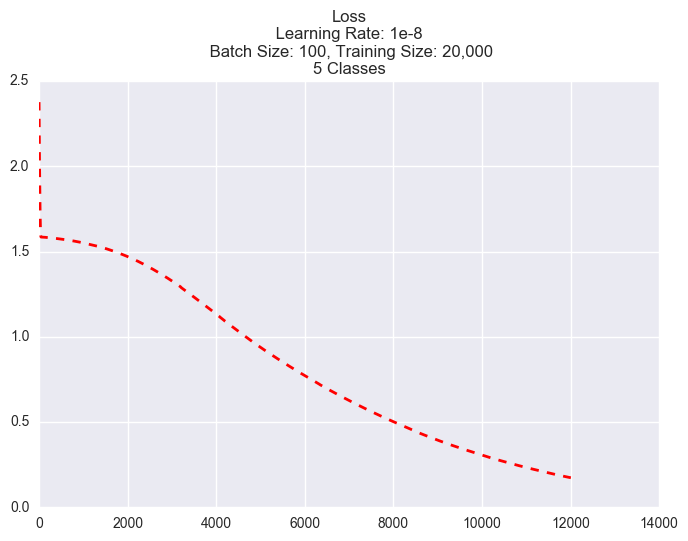

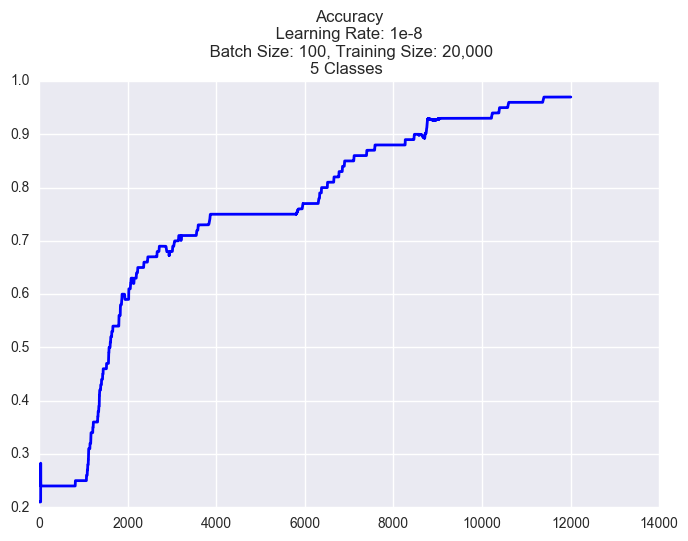

In [18]:
import seaborn

print len(loss_over_time)
plt.title("Loss\n Learning Rate: 1e-8 \n Batch Size: 100, Training Size: 20,000\n5 Classes")
plt.plot(np.arange(12008), loss_over_time, color='red', linestyle="--",
         linewidth=2, label='Loss')

#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.title("Accuracy\n Learning Rate: 1e-8 \n Batch Size: 100, Training Size: 20,000\n5 Classes ")
plt.plot(np.arange(12008), acc_over_time, color='blue', linestyle='-',
         linewidth=2, label='Accuracy')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()



In [20]:
print "test_data", test_data.shape, "test_labels:", test_labels.shape
print "-----------test model----------"
# Test model
avg_acc = 0.
total_batch = int((len(test_data))/batch_size)
b = -1

for j in range(total_batch):
    b+=1
    s  = b * batch_size
    e = (b+1) *batch_size
    # Fit training using batch data
    batchData1, batchLabels = next_batch(s, e, test_data, test_labels)
    tr_accuracy = sess.run(accuracy, feed_dict={images:batchData1, labels:batchLabels})
    avg_acc += tr_accuracy  

print "Test Accuracy: %0.2f" % (float(avg_acc)/total_batch)



test_data (5000, 25, 25, 2) test_labels: (5000, 5)
-----------test model----------


InvalidArgumentError: You must feed a value for placeholder tensor 'images' with dtype float
	 [[Node: images = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op u'images', defined at:
  File "/Users/Iris/anaconda/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/Iris/anaconda/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/Iris/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/Iris/anaconda/lib/python2.7/site-packages/traitlets/config/application.py", line 653, in launch_instance
    app.start()
  File "/Users/Iris/anaconda/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/Users/Iris/anaconda/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/Users/Iris/anaconda/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Users/Iris/anaconda/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/Iris/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/Iris/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/Iris/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/Iris/anaconda/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/Iris/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/Iris/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/Iris/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Users/Iris/anaconda/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/Iris/anaconda/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/Iris/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/Iris/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/Iris/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-f16b493e368b>", line 18, in <module>
    images = tf.placeholder( tf.float32, shape=[None, 25, 25, 2], name="images" )
  File "/Users/Iris/anaconda/lib/python2.7/site-packages/tensorflow/python/ops/array_ops.py", line 1587, in placeholder
    name=name)
  File "/Users/Iris/anaconda/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2043, in _placeholder
    name=name)
  File "/Users/Iris/anaconda/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/Users/Iris/anaconda/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/Iris/anaconda/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'images' with dtype float
	 [[Node: images = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]
